# Introduction

In this project, you will build a neural network of your own design to evaluate the MNIST dataset.

Some of the benchmark results on MNIST include can be found [on Yann LeCun's page](http://yann.lecun.com/exdb/mnist/) and include:

88% [Lecun et al., 1998](http://yann.lecun.com/exdb/publis/pdf/lecun-98.pdf)
95.3% [Lecun et al., 1998](http://yann.lecun.com/exdb/publis/pdf/lecun-98.pdf)
99.65% [Ciresan et al., 2011](http://people.idsia.ch/~juergen/ijcai2011.pdf)

MNIST is a great dataset for sanity checking your models, since the accuracy levels achieved by large convolutional neural networks and small linear models are both quite high. This makes it important to be familiar with the data.

## Imports

In [1]:
## This cell contains the essential imports you will need – DO NOT CHANGE THE CONTENTS! ##
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

## Load the Dataset

Specify your transforms as a list if you intend to .
The transforms module is already loaded as `transforms`.

MNIST is fortunately included in the torchvision module.
Then, you can create your dataset using the `MNIST` object from `torchvision.datasets` ([the documentation is available here](https://pytorch.org/vision/stable/datasets.html#mnist)).
Make sure to specify `download=True`! 

Once your dataset is created, you'll also need to define a `DataLoader` from the `torch.utils.data` module for both the train and the test set.

In [2]:
# Define transforms
## YOUR CODE HERE ##



import torchvision.datasets as datasets
import torchvision.transforms as transforms

# Define the transformations to apply to the data
transform = transforms.Compose([
    transforms.ToTensor(), # Convert image to tensor
    transforms.Normalize((0.1307,), (0.3081,)) # Normalize the image pixel values
])

# Load the MNIST dataset
train_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
test_dataset = datasets.MNIST(root='./data', train=False, transform=transform)

# Split the training dataset into training and validation sets
train_dataset, val_dataset = torch.utils.data.random_split(train_dataset, [50000, 10000])

# Create data loaders for the training, validation, and testing datasets
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=64, shuffle=False)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=False)


print(f'Training dataset size: {len(train_dataset)}')
print(f'Validation dataset size: {len(val_dataset)}')
print(f'Testing dataset size: {len(test_dataset)}')

Training dataset size: 50000
Validation dataset size: 10000
Testing dataset size: 10000


## Justify your preprocessing

In your own words, why did you choose the transforms you chose? If you didn't use any preprocessing steps, why not?

I have used the following transforms:
1. ToTensor():
    - converts the image into numbers, that are understandable by the system.
    - It separates the image into three color channels (separate images): red, green & blue.
    - Then it converts the pixels of each image to the brightness of their color between 0 and 255. 
    - These values are then scaled down to a range between 0 and 1. The image is now a Torch Tensor.

2. Normalize():
    - Normalizes the tensor with a mean and standard deviation (0.5 and 0.5) in our case

## Explore the Dataset
Using matplotlib, numpy, and torch, explore the dimensions of your data.

You can view images using the `show5` function defined below – it takes a data loader as an argument.
Remember that normalized images will look really weird to you! You may want to try changing your transforms to view images.
Typically using no transforms other than `toTensor()` works well for viewing – but not as well for training your network.
If `show5` doesn't work, go back and check your code for creating your data loaders and your training/test sets.

In [3]:
## This cell contains a function for showing 5 images from a dataloader – DO NOT CHANGE THE CONTENTS! ##
def show5(img_loader):
    dataiter = iter(img_loader)
    
    batch = next(dataiter)
    labels = batch[1][0:5]
    images = batch[0][0:5]
    for i in range(5):
        print(int(labels[i].detach()))
    
        image = images[i].numpy()
        plt.imshow(image.T.squeeze().T)
        plt.show()

7


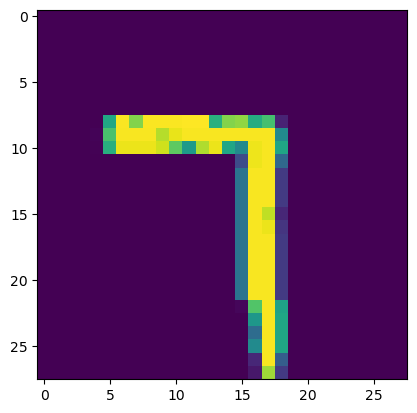

1


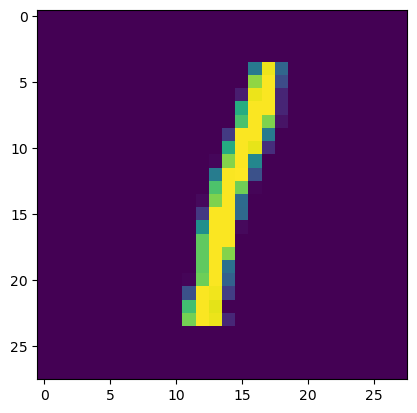

2


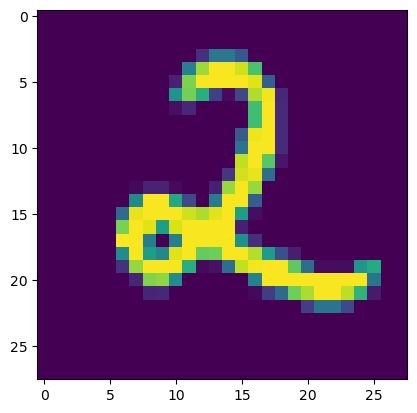

0


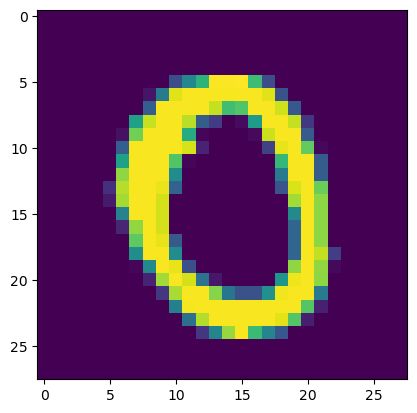

3


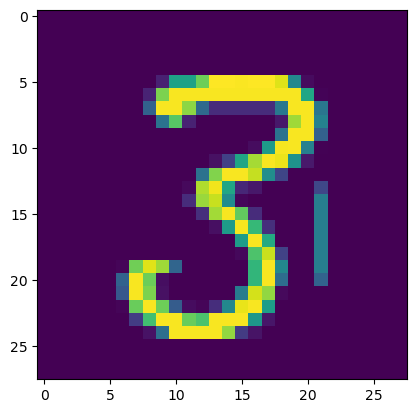

In [4]:
# Explore data
## YOUR CODE HERE ##
show5(train_loader)

## Build your Neural Network
Using the layers in `torch.nn` (which has been imported as `nn`) and the `torch.nn.functional` module (imported as `F`), construct a neural network based on the parameters of the dataset.
Use any architecture you like. 

*Note*: If you did not flatten your tensors in your transforms or as part of your preprocessing and you are using only `Linear` layers, make sure to use the `Flatten` layer in your network!

In [24]:
# Define the neural network
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.fc1 = nn.Linear(64*7*7, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = nn.functional.relu(self.conv1(x))
        x = nn.functional.max_pool2d(x, 2)
        x = nn.functional.relu(self.conv2(x))
        x = nn.functional.max_pool2d(x, 2)
        x = x.view(-1, 64*7*7)
        x = nn.functional.relu(self.fc1(x))
        x = nn.functional.dropout(x, training=self.training)
        x = self.fc2(x)
        return nn.functional.log_softmax(x, dim=1)

In [25]:
## YOUR CODE HERE ##
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


Specify a loss function and an optimizer, and instantiate the model.

If you use a less common loss function, please note why you chose that loss function in a comment.

In [26]:
## YOUR CODE HERE ##
criterion = nn.CrossEntropyLoss()
cnn_model = Net()
optimizer = optim.SGD(cnn_model.parameters(), lr=0.003, momentum=0.9)

# We have used LogSoftmax activation as the last layer (technically, it's the logarithm of a Softmax function) and CrossEntropyLoss()
# as it is a classification problem.

## Running your Neural Network
Use whatever method you like to train your neural network, and ensure you record the average loss at each epoch. 
Don't forget to use `torch.device()` and the `.to()` method for both your model and your data if you are using GPU!

If you want to print your loss **during** each epoch, you can use the `enumerate` function and print the loss after a set number of batches. 250 batches works well for most people!

In [39]:
# Define the training function
running_losses = []
epoch_loss = []
def train(model, device, train_loader, optimizer, epoch):
    running_loss = 0
    # Set the model to "train".
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        # Move the data to GPU/CPU device accordingly.
#         data, target = data.to(device), target.to(device)
        # flush out the existing gradients.
        optimizer.zero_grad()
        # Calculate the outputs of the model
        output = model(data)
        # Compute the loss.
        loss = criterion(output, target)
        # Compute the gradients.
        loss.backward()
        # Update the weights/biases variables.
        optimizer.step()
        # Add the loss to the running_loss.
        running_loss += loss.item()
        
        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
        running_losses.append(loss.item())
    else:
        epoch_loss.append(running_loss / len(train_loader))
            

# Define the testing function
test_losses = []
val_losses = []
def test(model, device, test_loader, validation=False):
    # Set the model to "eval" mode.
    model.eval()
    test_loss = 0
    correct = 0
    # Remove the gradient calculation part.
    with torch.no_grad():
        for data, target in test_loader:
#             data, target = data.to(device), target.to(device)
            output = model(data)
            # compute the test loss.
            test_loss += nn.functional.nll_loss(output, target, reduction='sum').item()
            # Get the maximum arguments of the outputs.
            pred = output.argmax(dim=1, keepdim=True)
            # Check the total number of correct predictions made by the model.
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)
    if validation:
        val_losses.append(test_loss)
    accuracy = 100. * correct / len(test_loader.dataset)
    print('Test set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)'.format(
        test_loss, correct, len(test_loader.dataset), accuracy))
    return test_loss, accuracy

In [28]:
# Training the CNN model for 50 epochs.
epochs = 50
for epoch in range(1, epochs+1):
    train(cnn_model, device, train_loader, optimizer, epoch)
    test(cnn_model, device, val_loader, validation=True)

Train Epoch: 1 [0/50000 (0%)]	Loss: 2.316394
Train Epoch: 1 [6400/50000 (13%)]	Loss: 0.859380
Train Epoch: 1 [12800/50000 (26%)]	Loss: 0.517394
Train Epoch: 1 [19200/50000 (38%)]	Loss: 0.415457
Train Epoch: 1 [25600/50000 (51%)]	Loss: 0.237596
Train Epoch: 1 [32000/50000 (64%)]	Loss: 0.254644
Train Epoch: 1 [38400/50000 (77%)]	Loss: 0.212937
Train Epoch: 1 [44800/50000 (90%)]	Loss: 0.268912
Test set: Average loss: 0.1237, Accuracy: 9632/10000 (96%)
Train Epoch: 2 [0/50000 (0%)]	Loss: 0.116643
Train Epoch: 2 [6400/50000 (13%)]	Loss: 0.112520
Train Epoch: 2 [12800/50000 (26%)]	Loss: 0.089383
Train Epoch: 2 [19200/50000 (38%)]	Loss: 0.111331
Train Epoch: 2 [25600/50000 (51%)]	Loss: 0.115228
Train Epoch: 2 [32000/50000 (64%)]	Loss: 0.229231
Train Epoch: 2 [38400/50000 (77%)]	Loss: 0.268521
Train Epoch: 2 [44800/50000 (90%)]	Loss: 0.094830
Test set: Average loss: 0.0792, Accuracy: 9764/10000 (98%)
Train Epoch: 3 [0/50000 (0%)]	Loss: 0.105871
Train Epoch: 3 [6400/50000 (13%)]	Loss: 0.082900


Train Epoch: 19 [6400/50000 (13%)]	Loss: 0.015171
Train Epoch: 19 [12800/50000 (26%)]	Loss: 0.011690
Train Epoch: 19 [19200/50000 (38%)]	Loss: 0.091531
Train Epoch: 19 [25600/50000 (51%)]	Loss: 0.010452
Train Epoch: 19 [32000/50000 (64%)]	Loss: 0.010027
Train Epoch: 19 [38400/50000 (77%)]	Loss: 0.070601
Train Epoch: 19 [44800/50000 (90%)]	Loss: 0.013525
Test set: Average loss: 0.0410, Accuracy: 9898/10000 (99%)
Train Epoch: 20 [0/50000 (0%)]	Loss: 0.031651
Train Epoch: 20 [6400/50000 (13%)]	Loss: 0.009300
Train Epoch: 20 [12800/50000 (26%)]	Loss: 0.011444
Train Epoch: 20 [19200/50000 (38%)]	Loss: 0.035627
Train Epoch: 20 [25600/50000 (51%)]	Loss: 0.004211
Train Epoch: 20 [32000/50000 (64%)]	Loss: 0.011451
Train Epoch: 20 [38400/50000 (77%)]	Loss: 0.021381
Train Epoch: 20 [44800/50000 (90%)]	Loss: 0.000997
Test set: Average loss: 0.0381, Accuracy: 9899/10000 (99%)
Train Epoch: 21 [0/50000 (0%)]	Loss: 0.005815
Train Epoch: 21 [6400/50000 (13%)]	Loss: 0.009205
Train Epoch: 21 [12800/50000

Test set: Average loss: 0.0395, Accuracy: 9912/10000 (99%)
Train Epoch: 37 [0/50000 (0%)]	Loss: 0.000960
Train Epoch: 37 [6400/50000 (13%)]	Loss: 0.125940
Train Epoch: 37 [12800/50000 (26%)]	Loss: 0.001320
Train Epoch: 37 [19200/50000 (38%)]	Loss: 0.003141
Train Epoch: 37 [25600/50000 (51%)]	Loss: 0.004204
Train Epoch: 37 [32000/50000 (64%)]	Loss: 0.021474
Train Epoch: 37 [38400/50000 (77%)]	Loss: 0.012275
Train Epoch: 37 [44800/50000 (90%)]	Loss: 0.002928
Test set: Average loss: 0.0358, Accuracy: 9913/10000 (99%)
Train Epoch: 38 [0/50000 (0%)]	Loss: 0.005885
Train Epoch: 38 [6400/50000 (13%)]	Loss: 0.017359
Train Epoch: 38 [12800/50000 (26%)]	Loss: 0.003643
Train Epoch: 38 [19200/50000 (38%)]	Loss: 0.001958
Train Epoch: 38 [25600/50000 (51%)]	Loss: 0.000107
Train Epoch: 38 [32000/50000 (64%)]	Loss: 0.001806
Train Epoch: 38 [38400/50000 (77%)]	Loss: 0.010101
Train Epoch: 38 [44800/50000 (90%)]	Loss: 0.004578
Test set: Average loss: 0.0409, Accuracy: 9903/10000 (99%)
Train Epoch: 39 [0/

Plot the training loss (and validation loss/accuracy, if recorded).

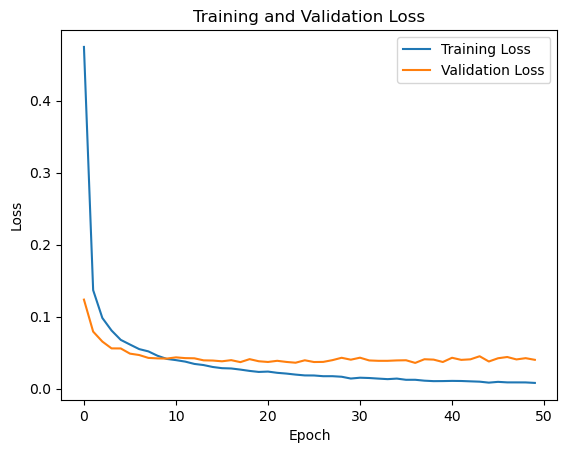

In [35]:
## YOUR CODE HERE ##
fig, ax = plt.subplots()
ax.plot(epoch_loss, label='Training Loss')
ax.plot(test_losses, label='Validation Loss')
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
ax.set_title('Training and Validation Loss')
ax.legend()

plt.show()

## Testing your model
Using the previously created `DataLoader` for the test set, compute the percentage of correct predictions using the highest probability prediction. 

If your accuracy is over 90%, great work, but see if you can push a bit further! 
If your accuracy is under 90%, you'll need to make improvements.
Go back and check your model architecture, loss function, and optimizer to make sure they're appropriate for an image classification task.

In [36]:
## YOUR CODE HERE ##
test(cnn_model, device, test_loader)

Test set: Average loss: 0.0250, Accuracy: 9932/10000 (99%)


(0.02500534263769223, 99.32)

## Improving your model

Once your model is done training, try tweaking your hyperparameters and training again below to improve your accuracy on the test set!

In [37]:
## YOUR CODE HERE ##
# We would be skipping this step, as the model has already achieved more than 90% accuracy on test dataset.

## Saving your model
Using `torch.save`, save your model for future loading.

In [38]:
## YOUR CODE HERE ##
torch.save(cnn_model, './saved_models')

In [32]:
# new_model = torch.load('./saved_models')